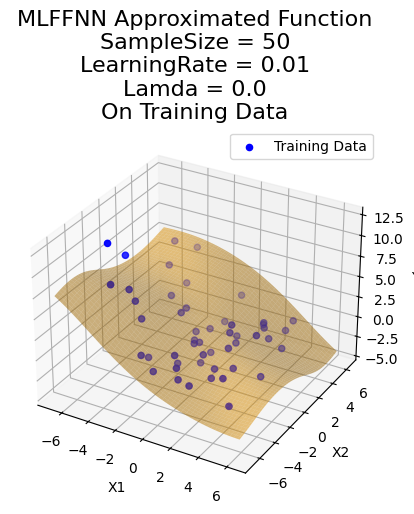

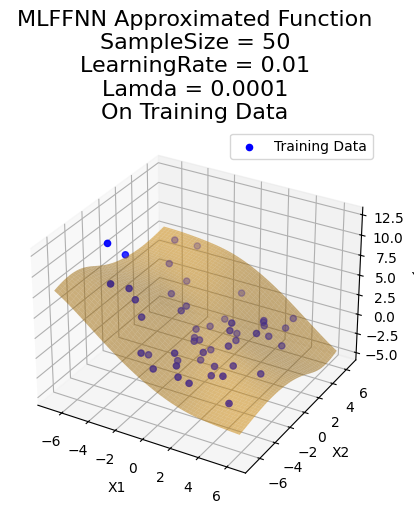

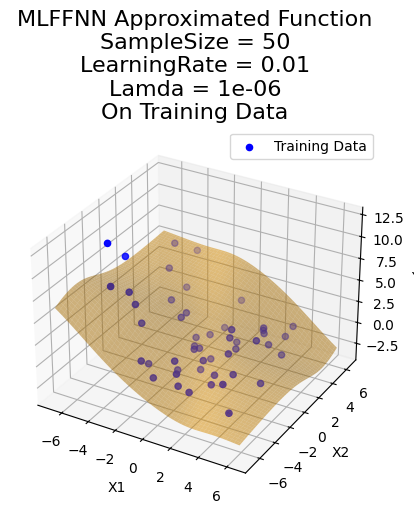

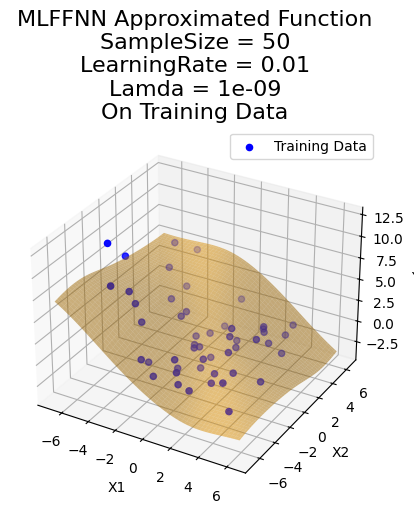

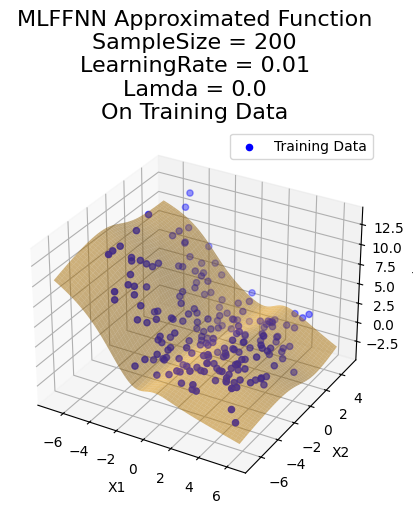

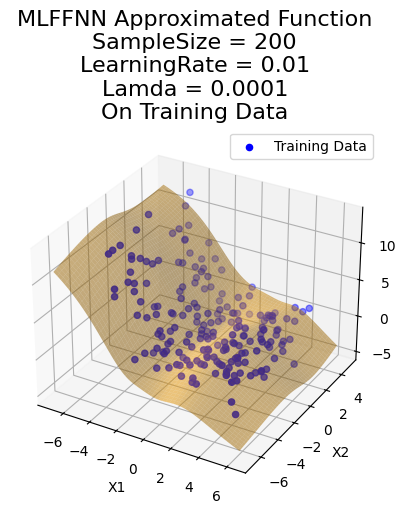

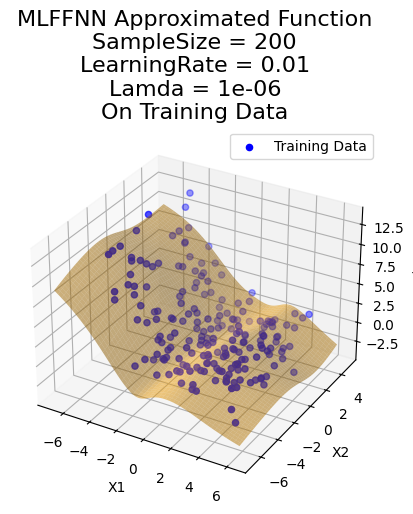

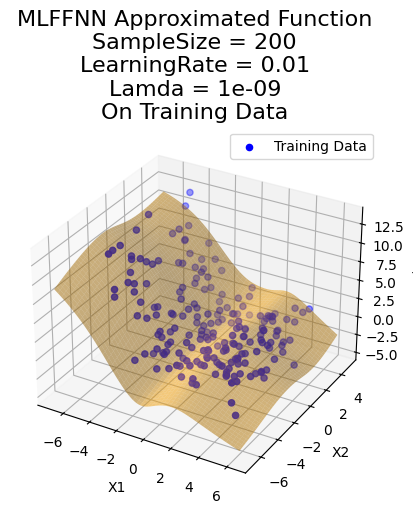

Index Sample Size  Learning Rate            λ  Train Erms  Validate Erms  Test Erms
    1          50           0.01 0.000000e+00    3.960528       4.340868   4.181695
    2          50           0.01 1.000000e-04    4.031042       4.382777   4.229537
    3          50           0.01 1.000000e-06    3.823454       4.258027   4.085939
    4          50           0.01 1.000000e-09    3.834126       4.272278   4.097346
    5         200           0.01 0.000000e+00    4.462734       4.743801   4.576480
    6         200           0.01 1.000000e-04    4.752466       5.062922   4.926897
    7         200           0.01 1.000000e-06    4.209902       4.544092   4.339498
    8         200           0.01 1.000000e-09    4.444054       4.760953   4.632024


In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

column_names = [
    "Index",
    "Sample Size",
    "Learning Rate",
    "λ",
    "Train Erms",
    "Validate Erms",
    "Test Erms",
]
table_index = 0
table_df = pd.DataFrame(columns=column_names)
fig = ""
ax = ""

def build_and_train_model(train_x, train_y, val_x, val_y, learning_rate, lamda):
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.L1(lamda), input_shape=(2,)),
            tf.keras.layers.Dense(1, activation='linear')
        ])
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=100, batch_size=32, verbose=0)

    return model


def evaluate_model(model, x, y):

    y_pred = model.predict(x, verbose=0)

    return y_pred

def add_data_to_table(sample_size, learning_rate, lamda, train_erms, validate_erms, test_erms):
    row_data = {}
    global table_df
    global table_index
    table_index = table_index + 1
    row_data["Index"] = table_index
    row_data["Sample Size"] = sample_size
    row_data["Learning Rate"] = learning_rate
    row_data["λ"] = lamda
    row_data["Train Erms"] = train_erms
    row_data["Validate Erms"] = validate_erms
    row_data["Test Erms"] = test_erms
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        table_df = pd.concat(
            [table_df, pd.DataFrame(row_data, index=[0])], ignore_index=True
        )


def print_table():
    print(table_df.to_string(index=False))

def get_N(x):
    N = len(x)
    return N

def get_erms(y, t):
    y_mse = tf.reduce_mean(tf.square(t-y))
    erms = np.sqrt(y_mse)
    return erms

def get_meshgrid(start_x1, stop_x1, start_x2, stop_x2, N):
    x1_range = np.linspace(start_x1, stop_x1, N)
    x2_range = np.linspace(start_x2, stop_x2, N)
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    
    input_grid = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))

    return (x1_grid, x2_grid, input_grid)

def plot_data(x, y, pred_y, x1_grid, x2_grid, y_pred_surface, x_color, y_color, scatter_label, plot_label, x_label, y_label, z_label, plot_title, legend):
    
    global fig
    fig = plt.figure()
    global ax
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(x[:, 0], x[:, 1], y, color=x_color, label=scatter_label)
    ax.plot_surface(x1_grid, x2_grid, y_pred_surface, color=y_color, alpha=0.5, label=plot_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    plot_title = plot_title + legend
    ax.set_title(plot_title, fontsize=16)
    ax.legend([scatter], [legend])
    current_directory = os.getcwd()
    os.makedirs(current_directory + "/reg_2", exist_ok=True)
    plt.savefig(current_directory + "/reg_2/" + plot_title + ".png")
    plt.show()

def plot_all_data(model, train_x, train_y, train_y_pred, val_x, val_y, val_y_pred, test_x, test_y, test_y_pred, sample_size, learning_rate, lamda):
    
    mesh_count = 100

    min_x1 = min(np.min(train_x[0]), np.min(val_x[0]), np.min(test_x[0]))-2
    max_x1 = max(np.max(train_x[0]), np.max(val_x[0]), np.max(test_x[0]))+2
    min_x2 = min(np.min(train_x[1]), np.min(val_x[1]), np.min(test_x[1]))-2
    max_x2 = max(np.max(train_x[1]), np.max(val_x[1]), np.max(test_x[1]))+2
    x1_grid, x2_grid, input_grid = get_meshgrid(min_x1, max_x1, min_x2, max_x2, mesh_count)
    
    title = "MLFFNN Approximated Function\nSampleSize = " + str(sample_size) + "\nLearningRate = " + str(learning_rate) + "\nLamda = "+str(lamda)+"\nOn "

    y_pred_train_surface = model.predict(input_grid, verbose=0).reshape(x1_grid.shape)
    plot_data(train_x, train_y, train_y_pred, x1_grid, x2_grid, y_pred_train_surface, 'blue', 'orange', 'Training Data', 'Approximated Function', 'X1', 'X2', 'Y', title, 'Training Data')


def plot_graphs(train_x, train_y, val_x, val_y, test_x, test_y, sample_size,  regularization_coefficients, learning_rate=0.1):

    for lamda in regularization_coefficients:
        model = build_and_train_model(train_x, train_y, val_x, val_y, learning_rate, lamda)
        
        train_y_pred = evaluate_model(model, train_x, train_y)
        val_y_pred = evaluate_model(model, val_x, val_y)
        test_y_pred = evaluate_model(model, test_x, test_y)

        train_erms = get_erms(train_y_pred, train_y)
        validate_erms = get_erms(val_y_pred, val_y)
        test_erms = get_erms(test_y_pred, test_y)
        
        plot_all_data(model, train_x, train_y, train_y_pred, val_x, val_y, val_y_pred, test_x, test_y, test_y_pred, sample_size, learning_rate, lamda)

        add_data_to_table(sample_size, learning_rate, lamda, train_erms, validate_erms, test_erms)
   

def main():
    folder_number = "18"
    current_directory = os.getcwd()
    regression_dataset_2_path=current_directory+ "/Datasets_for_A1/Regression/Dataset 2/" + folder_number + "/"
    
    regression_dataset_2_Train_Sample_1 = (
        regression_dataset_2_path + "train50_" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_2_Train_Sample_1)
    data = df.to_numpy()
    sorted_data = data[data[:, 1].argsort()]
    train_x_1 = sorted_data[:, :2]
    train_y_1 = sorted_data[:, 2]
    train_x_1 = train_x_1

    regression_dataset_2_Train_Sample_2 = (
        regression_dataset_2_path + "train200_" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_2_Train_Sample_2)
    data = df.to_numpy()
    sorted_data = data[data[:, 1].argsort()]
    train_x_2 = sorted_data[:, :2]
    train_y_2 = sorted_data[:, 2]
    train_x_2 = train_x_2

    regression_dataset_2_validation = (
        regression_dataset_2_path + "val_" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_2_validation)
    data = df.to_numpy()
    sorted_data = data[data[:, 1].argsort()]
    val_x = sorted_data[:, :2]
    val_y = sorted_data[:, 2]
    val_x = val_x

    regression_dataset_2_test = (
        regression_dataset_2_path + "test_" + folder_number + ".csv"
    )
    df = pd.read_csv(regression_dataset_2_test)
    data = df.to_numpy()
    sorted_data = data[data[:, 1].argsort()]
    test_x = data[:, :2]
    test_y = data[:, 2]
    test_x = test_x

    learning_rates = [0.01]
    regularization_coefficients = [0.0, 0.0001, 1e-6, 1e-9]

    sample_size = get_N(train_x_1)
    for learning_rate in learning_rates:
        plot_graphs(
            train_x_1,
            train_y_1,
            val_x,
            val_y,
            test_x,
            test_y,
            sample_size,
            regularization_coefficients,
            learning_rate,
        )

    sample_size = get_N(train_x_2)
    for learning_rate in learning_rates:
        plot_graphs(
            train_x_2,
            train_y_2,
            val_x,
            val_y,
            test_x,
            test_y,
            sample_size,
            regularization_coefficients,
            learning_rate,
        )

    print_table()


if __name__ == "__main__":
    main()